# Define the experimental ratios of elements


--> ERROR: The Zn element is not accepted by the pitzer database

--> ERROR: The Ni element is not accepted by the pitzer database

--> ERROR: The Cu element is not accepted by the pitzer database

--> ERROR: The Cd element is not accepted by the pitzer database

--> ERROR: The Co element is not accepted by the pitzer database

--> ERROR: The Pb element is not accepted by the pitzer database




Estimated completion in 3.80E1 seconds by 2022-01-02 00:13:19.068882 local time.


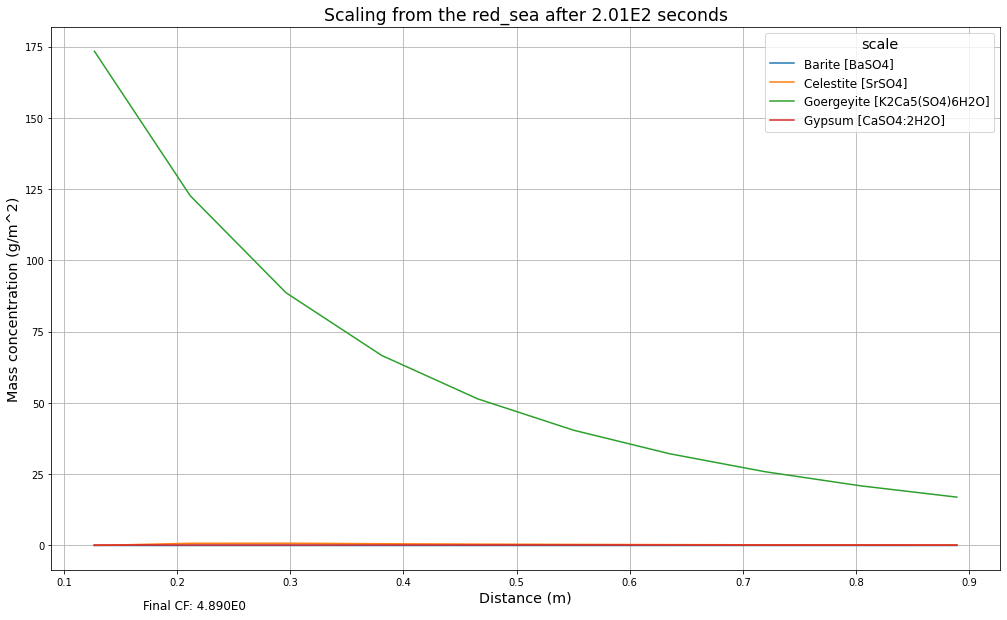

,Barite (g/m^2),Celestite (g/m^2),Goergeyite (g/m^2),Gypsum (g/m^2)
Distance (m),,,,
1.27E-1,0.00E0,0.00E0,1.73E2,0.00E0
2.12E-1,6.85E-4,7.76E-1,1.23E2,0.00E0
2.96E-1,8.11E-4,8.07E-1,8.87E1,0.00E0
3.81E-1,6.06E-4,6.16E-1,6.66E1,0.00E0
4.66E-1,4.61E-4,4.81E-1,5.14E1,0.00E0
5.50E-1,3.55E-4,3.81E-1,4.04E1,0.00E0
6.35E-1,2.75E-4,3.05E-1,3.22E1,0.00E0
7.20E-1,2.15E-4,2.46E-1,2.59E1,0.00E0
8.04E-1,1.68E-4,1.99E-1,2.09E1,0.00E0


In [38]:
# run the ROSS model
%run ../../../rosspy/core.py
ross = ROSSPkg(verbose = False)

# initial parameters
database_selection = 'pitzer'
water_selection = 'red_sea'
simulation_perspective = 'all_distance'
simulation_time = 200
final_cf = 5

# create the input file
ross.define_general(database_selection)
ross.transport(simulation_time, simulation_perspective, )
ross.reaction(final_cf)
ross.solutions(water_selection)
ross.equilibrium_phases()
ross.selected_output()
ross.export()

# execute and process the input file
raw_data = ross.execute()
distance_data = ross.process_selected_output()
display(distance_data)

In [34]:
from chemicals import periodic_table
from pprint import pprint
import json, re

elemental_masses = {}
for element in periodic_table:
    elemental_masses[element.symbol] = element.MW
    
# calculate the masses of each element in each scalant
mineral_elements = {}
stoich = None
total = 0
for column in distance_data:
    mineral = re.search('([A-Za-z]+)', column).group()
    database = json.load(open(f'./../../../rosspy/databases/{database_selection}.json'))
    formula = database["minerals"][mineral]['formula']
    formula = re.sub(':[0-9+]H2O|\(OH\)[0-9]+', '', formula)
    mineral_elements[mineral] = {}

    index = 0
    for ch in formula:
        if re.search('[A-Z]', ch):
            element = ch
            if re.search('[a-z]', formula[index+1]):
                element += formula[index+1]
                if re.search('[0-9]', formula[index+2]):
                    stoich = float(formula[index+2])
                else:
                    stoich = 1
            elif re.search('[0-9]', formula[index+1]):
                stoich = float(formula[index+1])
            else:
                stoich = 1
        elif re.search('[0-9]', ch):
            continue
            
        if element in elemental_masses:
            if stoich:
                mass = elemental_masses[element] * stoich
                total += mass
                mineral_elements[mineral][element] = mass
                stoich = None
                element = None
        
        index += 1
    
    mineral_elements[mineral]['total_moles'] = total

# pprint(mineral_elements)

# determine the ionic proportions of the respective mineral, without solvated water or hydroxide
elemental_ratio = {}
for mineral in mineral_elements:
    elemental_ratio[mineral] = {}
    for element in mineral_elements[mineral]:
        elemental_ratio[mineral][element] = mineral_elements[mineral][element] / mineral_elements[mineral]['total_moles']

# print('\n')
# pprint(elemental_ratio)

# calculate the precipitated mass of each element
scale_ratio = {}
elements = {}
for mineral in elemental_ratio:
    index = 0
    scale_ratio[mineral] = {}
    for scale in distance_data[f'{mineral} (g/m^2)']:  
        df_index = f'{distance_data.index[index]} (m)'
        scale_ratio[mineral][df_index] = {}
        if df_index not in elements:
            elements[df_index] = {}
            elements[df_index]['ion (g/m^2)'] = {}
        for element in elemental_ratio[mineral]:
            scale_ratio[mineral][df_index][element] = elemental_ratio[mineral][element] * float(scale)
            
            if element in elements[df_index]['ion (g/m^2)']:
                elements[df_index]['ion (g/m^2)'][element] += scale_ratio[mineral][df_index][element]
            elif element in elements[df_index]:
                elements[df_index][new_element] += scale_ratio[mineral][df_index][element]
            else:
                if element == 'total_moles':
                    elements[df_index][element] = scale_ratio[mineral][df_index][element]
                else:
                    elements[df_index]['ion (g/m^2)'][element] = scale_ratio[mineral][df_index][element]
            
        index += 1
    
# message = '\n\n(g/m^2) of elements per distance in the module'
# print(message, '\n', '='*len(message))
# pprint(scale_ratio)
pprint(elements)

# export the parsed scale ions
with open('scale_ions.json', 'w') as output:
    json.dump(elements, output, indent = 4)

{'1.27E-1 (m)': {'ion (g/m^2)': {'Ba': 0.0,
                                 'C': 3.611298515441389,
                                 'Ca': 0.0,
                                 'H': 1.2122431584017563,
                                 'K': 23.511640911234494,
                                 'O': 4.810594675410505,
                                 'S': 9.641093932712343,
                                 'Sr': 0.0},
                 'total_moles': 173.0},
 '2.12E-1 (m)': {'ion (g/m^2)': {'Ba': 0.0004030556417252525,
                                 'C': 2.5675706208051494,
                                 'Ca': 0.0,
                                 'H': 0.8618838640659886,
                                 'K': 16.716368971571345,
                                 'O': 3.539510465512148,
                                 'S': 6.914404500862144,
                                 'Sr': 0.1630248192039652},
                 'total_moles': 123.776685},
 '2.96E-1 (m)': {'ion (g/m^2)': {'Ba': 0.